# CBE 162 Fall 2024 Lab 10: IMC and Feedforward Control

### Objective:
This notebook explores the design and analysis of Internal Model Control (IMC) and feedforward controllers:
1. Designing IMC controllers for systems with and without time delay.
2. Analyzing the effect of feedforward control on disturbance rejection and setpoint tracking.


## Problem 1: IMC Design with Time Delay Approximations

### Subquestions:
1. Consider the process transfer function:
\
$$
G(s) = \frac{K}{(2s+1)(4s+1)} e^{-\theta s}
$$\
- Process parameters: \( K = 1.0 \), \( θ = 1.0 \).

   (a) Design an IMC controller, Find the equivalent Gc
and cast your controller in PID form with a filter.
     - Case 1: Ignore the time delay. Simulate the closed-loop response for a unit step change in set point upto t=20
     

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, step, lsim

# Define process transfer functions
K = 1.0
theta = 1.0

num_process = [-K*theta, K]
den_process = [8, 6, 1]

Gp = TransferFunction(num_process, den_process)
print(Gp)

TransferFunctionContinuous(
array([-0.125,  0.125]),
array([1.   , 0.75 , 0.125]),
dt: None
)


- Case 2: Use a first-order Padé approximation for the time delay.Simulate the closed-loop response for a unit step change in set point upto t=20.

   

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_16002/1109279644.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


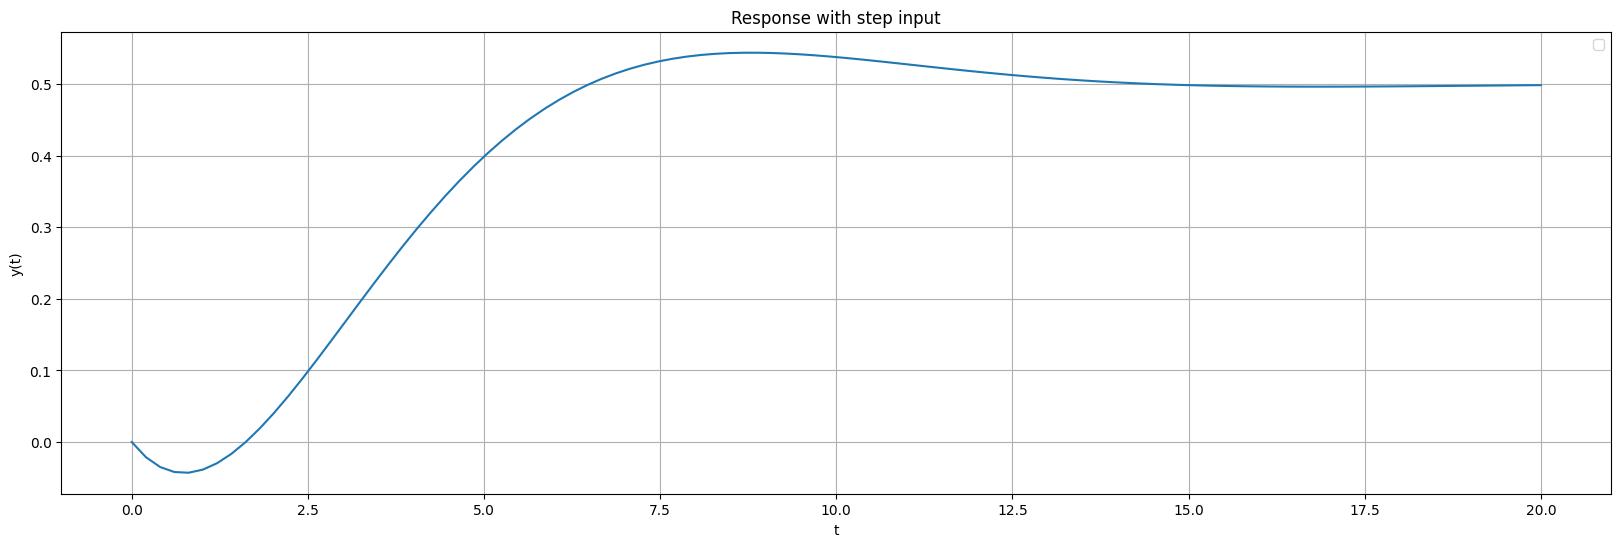

In [15]:
num_cl = np.polyadd(num_process, [0])
den_cl = np.polyadd(np.convolve(num_process, [1]), den_process)
Gcl = TransferFunction(num_cl, den_cl)

t = np.linspace(0, 20, 100)
y, t = step(Gcl, T=t)

plt.figure(figsize=(20, 6))
plt.plot(y, t)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Response with step input')
plt.grid()
plt.legend()
plt.show()


b) Simulate the closed-loop response for a unit step change in set point for \( $\tau_c$ = 2.0 \), \( $\tau_c$ = 5.0 \),and \( $\tau_c$ = 0.5 \) till t=20. Analyze and compare the results.

In [16]:
taucs = [0.5, 2.0, 5.0]
t = np.linspace(0, 20, 100)
tau = 15.0 # given by plot above

def compute_pid_parameters(K, theta, tauc, tau):
    """
    Gives parameters of standard pid controllers given parameters below
    params: gain (K), dead time (theta), controller (tauc), and time constant (tau)
    """
    Kc = tau/(K*(tauc + theta))
    taui = tau
    taud = (theta * tau) / (tau + theta)
    return Kc, taui, taud    

In [19]:
def closed_loop_response(tauc, K, theta, tau):
    """
    for a given set of pid parameters, the closed loop response is computed
    """
    Kc, taui, taud = compute_pid_parameters(K, theta, tauc, tau)

    num_pid = [Kc * taud, Kc, Kc / taui]
    den_pid = [1, 0]

    num_process = [K]
    den_process = [tau, 1]

    num_ol = np.convolve(num_pid, num_process) # in time space so we must convolve instead of just multiplying
    den_ol = np.convolve(den_pid, den_process)

    num_cl = num_ol
    den_cl = np.polyadd(den_ol, num_ol)

    system = TransferFunction(num_cl, den_cl)
    _, y, _ = lsim(system, U=np.ones_like(t), T=t)

    return y


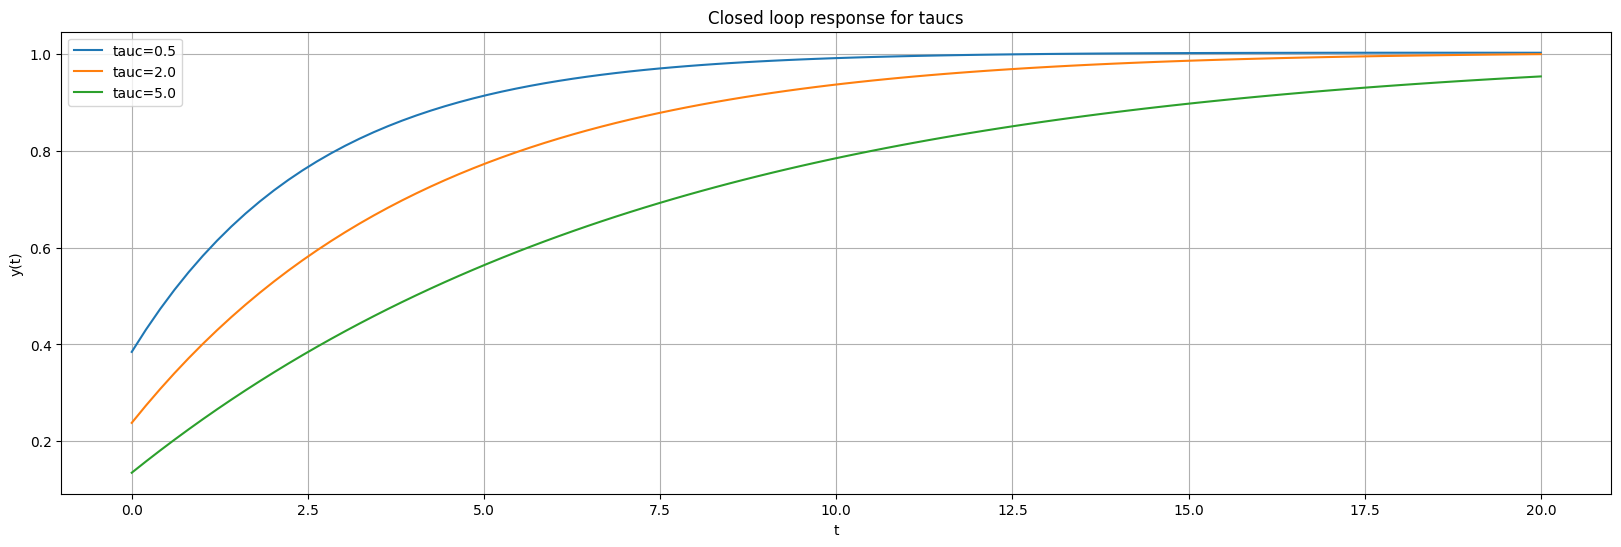

In [22]:
plt.figure(figsize=(20, 6))

for tauc in taucs:
    y = closed_loop_response(tauc, K, theta, tau)
    plt.plot(t, y, label=f'tauc={tauc}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Closed loop response for taucs')
plt.grid()
plt.legend()
plt.show()

## Problem 2: Feedforward Control Design and Analysis

### Subquestions:
1. Given the process:
\[$$
G_p = \frac{4(2s+1)}{2s^2+6s+1}, \quad G_v = \frac{4}{s+1}, \quad G_d = \frac{3}{6s+1}
]$$
- Design a feedforward controller \($ G_f$ \):


Design a feedback controller for this system (IMC) for this system.
2. Simulate a unit step in set point change given to the system, until t=42, with zero disturbance. At t=42, a unit step change is made to the disturbance. Simulate the response until t=84 :
   
   

In [49]:
Gp_num = [8, 4]
Gp_den = [2, 6, 1]

Gv_num = [4]
Gv_den = [1, 1]

Gd_num = [3]
Gd_den = [6, 1]

Gf_num = [6, 1]
Gf_den = [2, 6]

Kc = 1.5
t = np.linspace(0, 84, 1000)


Gv = TransferFunction(Gv_num, Gv_den)
Gd = TransferFunction(Gd_num, Gd_den)
Gp = TransferFunction(Gp_num, Gp_den)

ff_num = np.polymul(Gd_num, Gp_den)
ff_den = np.polymul(Gd_den, Gp_num)
ff = TransferFunction(ff_num, ff_den)

print(ff)

TransferFunctionContinuous(
array([0.125 , 0.375 , 0.0625]),
array([1.        , 0.66666667, 0.08333333]),
dt: None
)


Case 1: With feedforward control and feedback control.



In [56]:
Gf = TransferFunction(Gf_num, Gf_den)
Gv = TransferFunction(Gv_num, Gv_den)
Gf_Gv = TransferFunction(np.polymul(Gf_num, Gv_num), np.polymul(Gf_den, Gv_den))

Gp = TransferFunction(Gp_num, Gp_den)
Gp_fb_num = np.polymul(Kc, Gp_num)
Gp_fb_den = np.polyadd(Gp_den, np.polymul(Kc, Gp_num))

G_fb = TransferFunction(Gp_fb_num, Gp_fb_den)
_, y_ff_fb_setpoint = step(G_fb, T=t)
u_disturbance = np.zeros_like(t)
u_disturbance[t >= 42] = 1
_, y_ff_fb_disturbance, _ = lsim(Gd, u_disturbance, t)

y_ff_fb_total = y_ff_fb_setpoint + y_ff_fb_disturbance


Case 2: With only feedback control.

In [73]:
G_fb_only = TransferFunction(Gp_fb_num, Gp_fb_den)
_, y_fb_setpoint = step(G_fb_only, T=t)
_, y_fb_disturbance, _ = lsim(Gd, u_disturbance, t)

y_fb_total = y_fb_setpoint + y_fb_disturbance**(1/3)


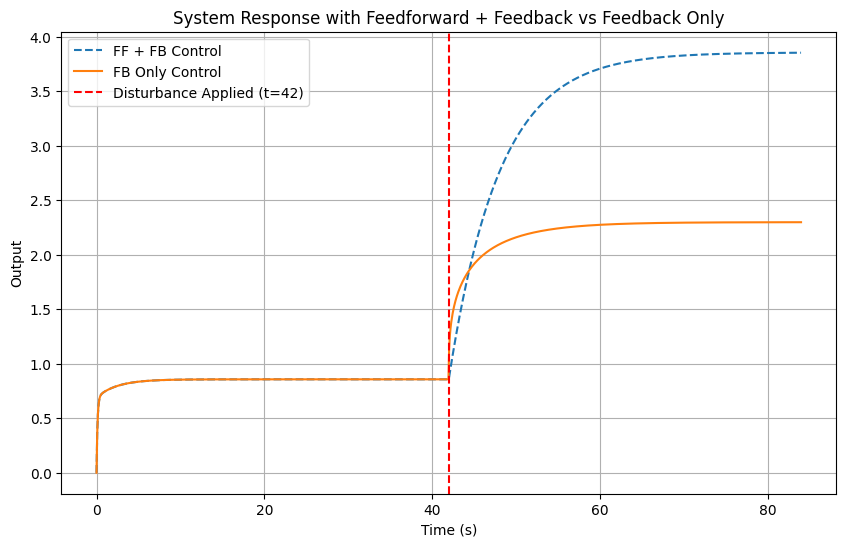

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(t, y_ff_fb_total, label="FF + FB Control", linestyle='dashed')
plt.plot(t, y_fb_total, label="FB Only Control", linestyle='solid')
plt.axvline(x=42, color='red', linestyle='--', label="Disturbance Applied (t=42)")
plt.title("System Response with Feedforward + Feedback vs Feedback Only")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()

Analyze and compare the response in each case. Does the presence of a feedforward controller improve the response?

The feedback and feedforward combination of controllers has a greater response and takes marginally longer while only the feedback controller has a lower response and is quicker to reach a steady state value.